In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
from sklearn.feature_selection import mutual_info_regression
%matplotlib inline

In [4]:
#hide_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.decomposition import PCA

In [53]:
df = pd.read_csv('data/CA-Data/ca.csv')
df.head()    

,DATE,STATUS,QLANG,DEM_GENDER,DEM_AGE,DEM_ABOR,DEM_ABOR_TYPE,DEM_STDNT,DEM_VET,DEM_HEALTH,...,FENT_NMU_NTY,HYD_NMU_NTY,HYDM_NMU_NTY,METH_NMU_NTY,MORPH_NMU_NTY,OXY_NMU_NTY,OXYM_NMU_NTY,SUF_NMU_NTY,TAP_NMU_NTY,TRAM_NMU_NTY
0,2017-09-28 18:13:25,3,1,1,18,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-10-18 18:46:34,3,1,1,18,0,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-09-29 06:58:50,3,1,1,24,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-10-03 17:58:19,3,1,1,16,0,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-10-25 21:09:49,3,1,1,21,0,NaN,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#hide_input
print("df.shape: " + str(df.shape))

df.shape: (10007, 185)


## Data cleaning/ Feature engineering

In [55]:
#hide_input
has_nulls = set(df.columns[df.isnull().sum()!=0])
print("There are "+str(len(has_nulls))+" many cols with at least one null value")
print(has_nulls)

There are 41 many cols with at least one null value
{'OXY_NMU', 'THC_NMU', 'PAIN_ACUTE_DOC', 'HELP_SUB_USE_PREDRGS', 'BUP_NMU', 'OPIOID_DEP_OTH', 'MORPH_NMU', 'COTC_NMU', 'HEALTH_RX', 'PAIN_CHRONIC_RX', 'HPC_SELL', 'HEALTH_SETTING_HOS', 'DEM_PREGMNTH', 'HEALTH_SETTING_OTH', 'COD_NMU', 'OPIOID_DEP_BUP', 'OXYM_NMU', 'HPC_USE', 'HYDM_NMU', 'DEM_ABOR_TYPE', 'HELP_SUB_USE_ALC', 'TRAM_NMU', 'HEALTH_SETTING_OUT', 'PAIN_ACUTE_RX', 'OPIOID_DEP_METH', 'OPIOID_DEP_HER', 'DEM_PREG', 'HEALTH_SETTING_PRIV', 'TAP_NMU', 'STIM_NMU', 'PAIN_CHRONIC_DOC', 'HEALTH_SETTING_PRE', 'SUF_NMU', 'METH_NMU', 'HYD_NMU', 'BENZ_NMU', 'HEALTH_ROLE', 'FENT_NMU', 'HEALTH_SETTING_HOME', 'OPIOID_DEP_NO', 'HELP_SUB_USE_OTH'}


feature with most nans: DEM_PREGMNTH with 9928


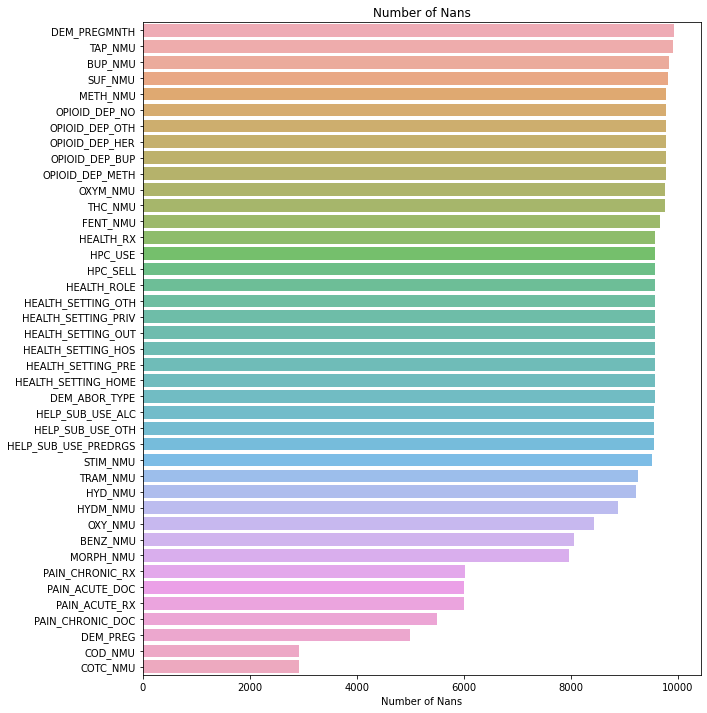

In [56]:
#hide_input
nan_count = df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False)
print("feature with most nans: DEM_PREGMNTH with " + str(nan_count[0]))
fig, axs = plt.subplots(figsize=(10, 12))
sns.barplot(y = nan_count.index, 
            x = nan_count.values, 
            alpha = 0.8
           )
plt.title('Number of Nans')
plt.xlabel('Number of Nans')
plt.show()

### Let us fill null values 
DEM_PREGMNTH - remove this column (MONTH into pregrenancy gives too little info and too little observation) <br>
X_NMU - We can fill all of these with 0 (No) which makes logical sense from survey's structure.<br>
OPIOD_DEP_X - fill with 0 (No)<br>
HEALTH_RX - fill with 0 (No)<br>
HPC_USE, HPC_SELL - Corresponds to health professionals and only their answers (can fill with -1)<br>
HEALTH_ROLE - fill with 6 (not a current healthcare professional) Can remove DEM_HEALTH<br>
HEALTH_SETTING_X - fill with -1 (not a current healthcare professional)<br>
DEM_ABOR_TYPE - fill with 4 (not Aboriginal person) Can remove DEM_ABOR<br>
HELP_SUB_USE_X - fill with 0 (No) <br>
PAIN_CHRONIC_RX, PAIN_CHRONIC_DOC - fill with 0 (No)<br>
PAIN_ACUTE_X - fill with 0 (No)<br>
DEM_PREG - fill with 0 (No b/c male)<br>

In [57]:
#hide_input
fill_w_zero = ['HYD_NMU', 'TAP_NMU', 'PAIN_CHRONIC_RX', 'COD_NMU', 'MORPH_NMU', 'OPIOID_DEP_METH', 'BENZ_NMU', 'PAIN_CHRONIC_DOC', 'OPIOID_DEP_BUP', 'HELP_SUB_USE_OTH', 'HYDM_NMU', 'PAIN_ACUTE_RX', 'FENT_NMU', 'HELP_SUB_USE_PREDRGS', 'METH_NMU', 'PAIN_ACUTE_DOC', 'TRAM_NMU', 'COTC_NMU', 'OPIOID_DEP_NO', 'BUP_NMU', 'OXYM_NMU', 'HELP_SUB_USE_ALC', 'OPIOID_DEP_HER', 'SUF_NMU', 'DEM_PREG', 'THC_NMU', 'OPIOID_DEP_OTH', 'HEALTH_RX', 'OXY_NMU', 'STIM_NMU']
for col in fill_w_zero:
    df[col].fillna(0, inplace=True) 
df = df.drop(['DEM_PREGMNTH'], axis=1)#, 'DEM_ABOR', 'DEM_HEALTH'], axis=1)
df['HEALTH_ROLE'].fillna(6, inplace=True)
df['DEM_ABOR_TYPE'].fillna(4, inplace=True)
# df['HPC_USE', 'HPC_SELL', 'HEALTH_SETTING_PRE', 'HEALTH_SETTING_HOS', 'HEALTH_SETTING_OUT', 'HEALTH_SETTING_HOME', 'HEALTH_SETTING_PRIV', 'HEALTH_SETTING_OTH'].fillna(-1)
fill_w_neg = ['HPC_USE', 'HPC_SELL', 'HEALTH_SETTING_PRE', 'HEALTH_SETTING_HOS', 'HEALTH_SETTING_OUT', 'HEALTH_SETTING_HOME', 'HEALTH_SETTING_PRIV', 'HEALTH_SETTING_OTH']
for col in fill_w_neg:
    df[col].fillna(-1, inplace=True)

In [58]:
#hide_input
has_nulls = set(df.columns[df.isnull().sum()!=0])
print("There are "+str(len(has_nulls))+" many cols with at least one null value")

There are 0 many cols with at least one null value


## Question one: Is DRSHOP_NMU a good response variable?<br>
(62. Have you ever attempted to get a prescription from a physician for a medication that you did not need and intended to misuse?) <br>
How does this question relate to following similar questions? <br> (67. Have you used drugs other than those required for medical reasons?) and <br>(63. Have you ever attempted to get a prescription from a physician for a medication that you did not need and intended to sell? )

Percentage of admit guilty DRSHOP_NMU:  0.01299090636554412
Percentage of admit guilty DRSHOP_SELL:  0.01648845807934446
Percentage of admit guilty DAST_1:  0.19926051763765365


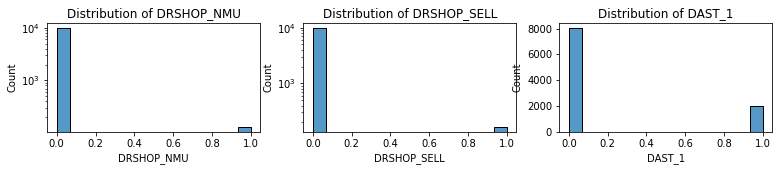

In [60]:
#hide_input
# Is DRSHOP_NMU a good response variable?
print("Percentage of admit guilty DRSHOP_NMU:  "+str(df.DRSHOP_NMU.mean()))
print("Percentage of admit guilty DRSHOP_SELL:  "+str(df.DRSHOP_SELL.mean()))
print("Percentage of admit guilty DAST_1:  "+str(df.DAST_1.mean()))
fig, ax = plt.subplots(1,3, figsize=(13,2))
fig.axes[0].set_title("Distribution of DRSHOP_NMU")
fig.axes[1].set_title("Distribution of DRSHOP_SELL")
fig.axes[2].set_title("Distribution of DAST_1")
drshop_nmu_dist = sns.histplot(df, x="DRSHOP_NMU", ax=ax[0]).set_yscale("log")
drshop_sell_dist = sns.histplot(df, x="DRSHOP_SELL", ax=ax[1]).set_yscale("log")
dast_1_dist = sns.histplot(df, x="DAST_1", ax=ax[2])

1. About 1.3%(130) of participants admitted to attempting to abuse presubscribed drug to misusage. <br>
2. About 1.65%(165) of participants admitted to attempting to misuse presubscribed drug by selling.
<br>
3. About 19.93%(1994) of participants admitted to using drugs other than medical reasons. 

## Let us define our binary response variable 'nmu' 

In [61]:
#hide_input
nmu_df = df.filter(like="NMU", axis=1)
df['NMU'] = nmu_df.sum(axis=1) > 0
df.NMU = df.NMU.astype(int)

In [62]:
#hide_input
print("Percentage of misuse:  "+str(df.NMU.mean()))

Percentage of misuse:  0.3360647546717298


Comment: our response variable 'NMU' corresponds to anyone who have at least once used drug as non medical use defined by the survey data.

## Data wrangling for prediction

In [63]:
#hide_input
## columns we don't need
cols_to_remove = ['DATE', 'QTIME', 'START_DATE', 'STATUS', 'VMOBILEDEVICE','ORDER_FENT','ORDER_BUP'
,'ORDER_METH'
,'ORDER_MORPH'
,'ORDER_OXY'
,'ORDER_OXYM'
,'ORDER_TRAM'
,'ORDER_TAP'
,'ORDER_COD'
,'ORDER_HYD'
,'ORDER_HYDM'
,'ORDER_SUF'
,'DEM_POSTAL','WT']


Justification on dropped columnes.
DATE, QTIME, ORDER_X, START_DATE, STATUS, VMOBILEDEVICE - We assume all survey were answered truthfully. <br>
DEM_POSTAL - DEM_REGION is good enough <br>


In [64]:
#hide_input
# Creat X dataframe (predictors) and y dataframe (response variable)
X = df.copy().drop(cols_to_remove, axis=1)
X = X.drop(nmu_df.columns, axis=1)
X = X.drop('NMU', axis=1)
y = df.pop('NMU')

Index(['FENT_NMU', 'BUP_NMU', 'METH_NMU', 'MORPH_NMU', 'OXY_NMU', 'OXYM_NMU',
       'TRAM_NMU', 'TAP_NMU', 'COD_NMU', 'COTC_NMU', 'HYD_NMU', 'HYDM_NMU',
       'SUF_NMU', 'STIM_NMU', 'BENZ_NMU', 'THC_NMU', 'DRSHOP_NMU',
       'OP_NMU_EVER', 'GABA_NMU_EVER', 'BENZ_NMU_EVER', 'STIM_NMU_EVER',
       'OP_NMU_YR', 'BENZ_NMU_YR', 'STIM_NMU_YR', 'GABA_NMU_YR', 'OP_NMU_NTY',
       'OP_NMU_MNTH', 'OP_NMU_WK', 'BENZ_NMU_NTY', 'BENZ_NMU_MNTH',
       'BENZ_NMU_WK', 'STIM_NMU_NTY', 'STIM_NMU_MNTH', 'STIM_NMU_WK',
       'GABA_NMU_NTY', 'GABA_NMU_MNTH', 'GABA_NMU_WK', 'BUP_NMU_NTY',
       'COD_NMU_NTY', 'COTC_NMU_NTY', 'FENT_NMU_NTY', 'HYD_NMU_NTY',
       'HYDM_NMU_NTY', 'METH_NMU_NTY', 'MORPH_NMU_NTY', 'OXY_NMU_NTY',
       'OXYM_NMU_NTY', 'SUF_NMU_NTY', 'TAP_NMU_NTY', 'TRAM_NMU_NTY'],
      dtype='object')

In [71]:
# Save to csv file
# df.to_csv("data/cleaned_ca.csv")
# X.to_csv("data/X.csv")
# y.to_csv("data/y.csv")

## Mutual Information

Mutual Information:
The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target? [source](https://www.kaggle.com/ryanholbrook/mutual-information)

In [13]:
#hide_input
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [66]:
#hide_input
mi_scores = make_mi_scores(X, y)

In [69]:
#hide_input
mi_scores[::]

OP_USE                 0.055316
COD_USE                0.039192
DAST_CAT               0.031276
WT                     0.030001
NPFENT_USE             0.029648
                         ...   
HEALTH_SETTING_HOME    0.000000
HEALTH_RX              0.000000
FENT_USE               0.000000
OXY_USE                0.000000
DAST_7                 0.000000
Name: MI Scores, Length: 116, dtype: float64

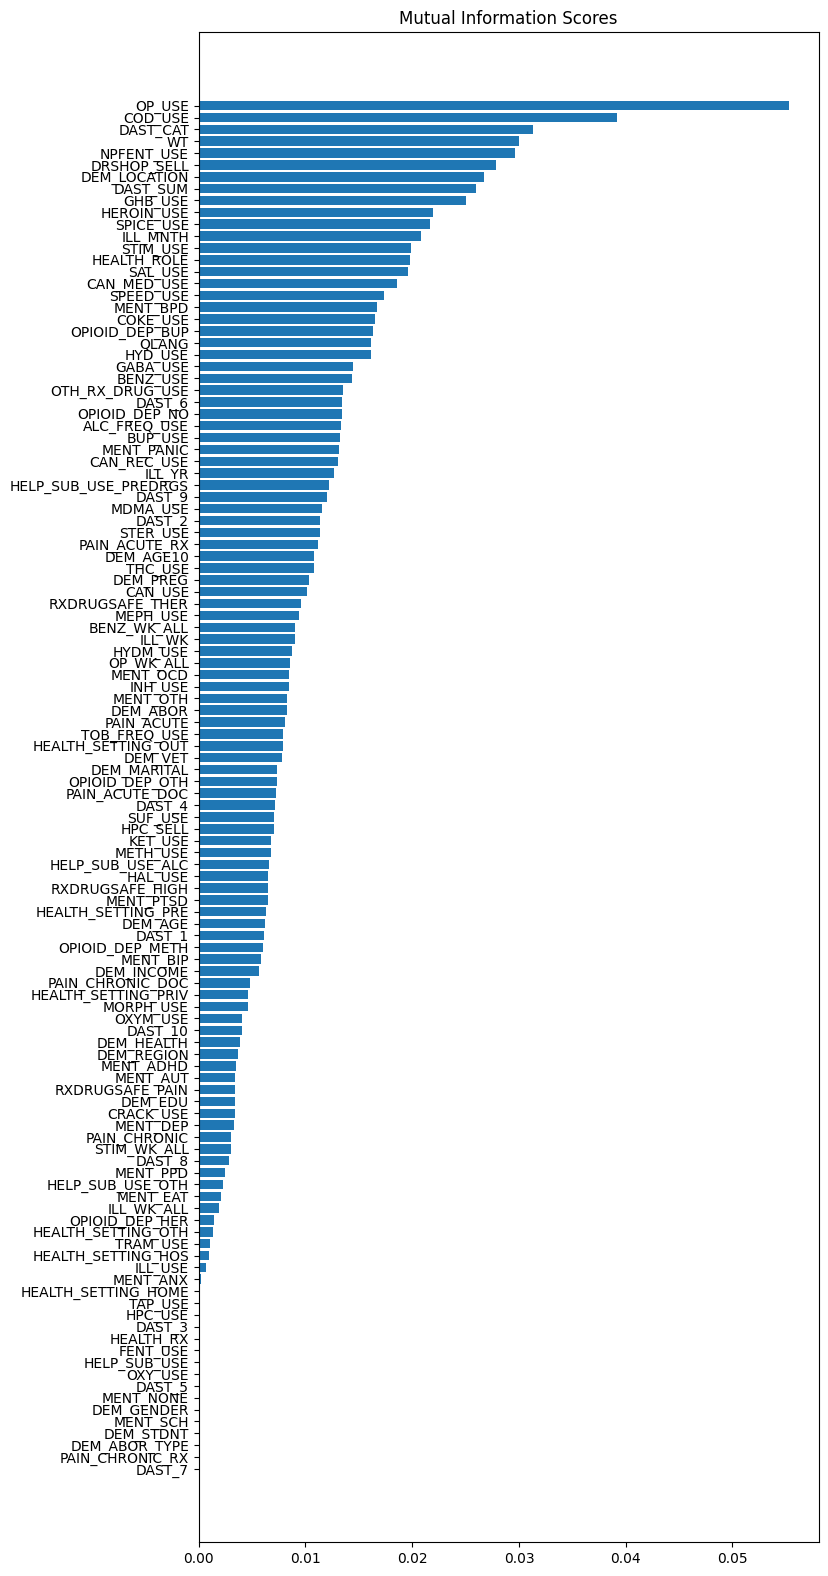

In [70]:
#hide_input
plt.figure(dpi=100, figsize=(8,20))
plot_mi_scores(mi_scores)

DAST_SUM = DAST-10 Score (0 to 10, 10 is most severe)  This is leaked information<br>
DAST_CAT = basically DAST-10 but categorical (5 levels) This is leaked information<br>
INH_USE = Inhalants (glue, gasolines, solvents, etc) (51) <br>
BENZ_NMU_MNTH - any benzodiazepine API last 30 day non-medical use (Z-drugs excluded) <br>
COKE_USE - Cocaine Powder (51) <br>
OXY_USE - Have you ever used Oxycodone (Oxy·IR®, OxyNEO®, Targin®, Percocet®, OxyContin®, Supeudol®, percs, OCs, oxy, oxy80, etc.)? (25) <br>
DEM_REGION - should be categorical (7) could be b/c WEST has way more provinces/territories
STIM_USE - Have you ever used a prescription stimulant (Adderall®, Elvanse®, Vyvanse®, Ritalin®, Concerta®, Strattera®, Dexedrine®, etc.)? This does NOT include store-bought, non-pharamaceutical, or over-the-counter stimulants (42) <br>
GABA_NMU_EVER, GABA_NMU_WK but no GABA_NMU_YR, MNTH, NTY <br>
DRSHOP_SELL - KIND OF A LEAK <br>
RXDRUGSAFE_HIGH - believe prescription drugs are safer than illicit drugs (to get high) (61)<br>
DEM_MARITAL - marital status (9)<br>
DAST_8 - have you done illegal activity to get drugs? (74)<br>
EVERY NMU is probably leaked information


# Modelling section

In [72]:
#hide_output
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

## Categorical variables

In [111]:
def create_dummy_df(df, cat_cols):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    
    OUTPUT:
    df - new dataframe with following characteristics:
        1. contains all columns that were not specified as categorical
        2. removes all the original columns in cat_cols
        3. dummy columns for each of the categorical columns in cat_cols
        4. Use a prefix of the column name with an underscore (_) for separating
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    return df


In [113]:
binary_cols = [col for col in X if np.isin(df[col].dropna().unique(), [0,1]).all()]
cat_df = X.drop(binary_cols, axis=1).drop('DEM_AGE', axis=1)
X_dummy = create_dummy_df(X, cat_df.columns)

In [115]:
X_dummy.columns

Index(['DEM_AGE', 'DEM_ABOR', 'DEM_STDNT', 'DEM_VET', 'DEM_HEALTH', 'DEM_PREG',
       'HEALTH_RX', 'FENT_USE', 'BUP_USE', 'METH_USE',
       ...
       'DAST_SUM_5', 'DAST_SUM_6', 'DAST_SUM_7', 'DAST_SUM_8', 'DAST_SUM_9',
       'DAST_SUM_10', 'DAST_CAT_2', 'DAST_CAT_3', 'DAST_CAT_4', 'DAST_CAT_5'],
      dtype='object', length=298)

## Standardizing Data

In [132]:
# Only age is continous
#X_scaled_test = (X_dummy - X_dummy.mean(axis=0))/X_dummy.std(axis=0)
X_dummy[['DEM_AGE']] = StandardScaler().fit_transform(X_dummy[['DEM_AGE']]);

# #hide_input
# has_nulls = set(X_scaled_test.columns[X_scaled_test.isnull().sum()!=0])
# print("There are "+str(len(has_nulls))+" many cols with at least one null value")


In [150]:
#X_dummy.to_csv("data/X_scaled_dummied.csv")
len(X_dummy.columns)

298

## Principal Component Analysis 
[source](https://www.kaggle.com/ryanholbrook/principal-component-analysis)

In [15]:
# hide_input
import io
X_dummy = pd.read_csv('data/X_scaled_dummied.csv')
X_dummy = pd.read_csv(io.StringIO(X_dummy.to_csv(index=False)), index_col=0)
y = pd.read_csv('data/y.csv')
y = pd.read_csv(io.StringIO(y.to_csv(index=False)), index_col=0)
#X_dummy.drop('Unnamed: 0', axis=1)

In [7]:
# hide_input
pca = PCA()
X_pca = pca.fit_transform(X_dummy)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X_dummy.columns)

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

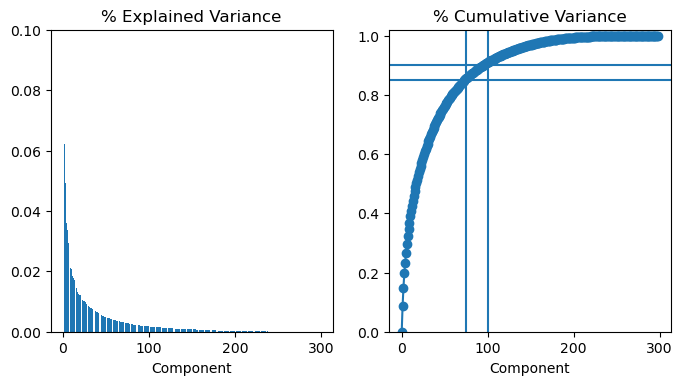

In [8]:
# hide_input
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize = (25,4))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.1)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.02)
    )
    axs[1].axvline(x=75)
    axs[1].axvline(x=100)
    axs[1].axhline(y=0.85)
    axs[1].axhline(y=0.9)
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
plot_variance(pca)

So we can capture about 0.85 of total variances with just 75 components out of 298 total components. <br>
We can also capture about 0.9 of total variances with just 100 components out of 298 total components.

In [9]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298
DEM_AGE,-0.790672,0.147304,0.116252,0.141724,-0.251737,0.105024,0.062000,-0.067292,0.098408,0.078352,...,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00
DEM_ABOR,0.040954,0.032332,-0.011014,0.075395,-0.041410,0.014765,-0.012804,0.018559,0.028940,0.061975,...,-1.189754e-02,-9.125266e-02,6.251768e-02,-4.785397e-02,-2.077696e-02,-1.228940e-02,4.457194e-03,-1.740794e-02,-6.884361e-03,1.653074e-02
DEM_STDNT,0.091142,-0.030090,-0.019372,0.002530,0.031825,-0.005623,0.003854,0.007088,-0.025012,-0.044856,...,-7.112366e-17,7.285839e-17,-6.765422e-17,4.510281e-17,1.474515e-17,1.621966e-16,-1.756408e-17,6.895526e-17,7.003946e-17,2.255141e-17
DEM_VET,-0.015201,0.009325,-0.000187,0.007106,-0.021695,-0.002685,0.002637,0.003755,0.013811,-0.014412,...,9.389191e-17,-4.076600e-17,-6.678685e-17,-1.279359e-17,-3.480289e-17,-5.740851e-17,-4.000706e-17,-2.417771e-17,-4.103705e-17,5.144539e-17
DEM_HEALTH,0.023648,0.002699,-0.010666,-0.020476,0.044541,0.036533,-0.036745,0.084051,0.280256,0.007469,...,-2.082817e-02,-2.728175e-02,-1.242540e-02,-1.506163e-02,1.068858e-02,-1.806720e-02,-2.049010e-02,1.661678e-02,1.519798e-03,-8.695375e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAST_SUM_10,0.001101,0.000889,0.000868,0.001079,-0.000474,0.000164,0.002212,-0.000782,-0.000379,0.000291,...,-4.129934e-02,-1.819856e-01,-4.006866e-01,1.326017e-02,-2.793979e-01,2.115656e-01,9.753602e-02,-7.343153e-02,1.955432e-02,-5.386034e-02
DAST_CAT_2,0.071501,-0.074389,0.063752,-0.346991,-0.386085,0.292126,-0.080621,-0.011858,-0.033871,-0.078345,...,8.897484e-03,1.490404e-02,-2.814780e-02,-5.437410e-02,-2.851301e-02,3.019288e-02,-1.448435e-02,-4.902497e-03,2.083750e-02,-6.282798e-03
DAST_CAT_3,0.055070,0.066504,0.032047,0.099945,-0.030389,-0.027131,0.033877,0.013001,0.017787,0.038970,...,1.048437e-01,-4.827113e-02,-3.556327e-02,-7.315412e-02,-4.312048e-02,3.660180e-02,-3.696965e-02,2.747022e-02,5.080501e-02,-1.726617e-02
DAST_CAT_4,0.016156,0.018516,0.014873,0.032213,-0.009185,-0.001960,0.009867,-0.002431,0.002494,-0.005335,...,1.250905e-01,1.054437e-02,-1.640688e-01,-4.132924e-01,9.862945e-02,2.399420e-01,2.430765e-01,-9.559380e-03,9.194460e-02,1.262299e-02


Brief interpretation: PC1 corresponds to unique feature where very young people who are a little bit aboriginal, little bit Student, not very much Vetenerian, and so on. PC290 is where they are not much anything

In [10]:
# hide_input
pca2 = PCA(n_components=75)
principal_comps = pca2.fit_transform(X_dummy)
p_df = pd.DataFrame(principal_comps)

In [11]:
pca3 = PCA(n_components=100)
principal_comps = pca3.fit_transform(X_dummy)
p_df2 = pd.DataFrame(principal_comps)
p_df2
p_df2.to_csv("data/principal_component_df100.csv")

In [20]:
mi_scores2 = make_mi_scores(X_pca, y)
mi_scores2

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


PC3      0.043318
PC10     0.033993
PC249    0.027969
PC4      0.025390
PC129    0.025357
           ...   
PC32     0.000000
PC31     0.000000
PC93     0.000000
PC96     0.000000
PC97     0.000000
Name: MI Scores, Length: 298, dtype: float64

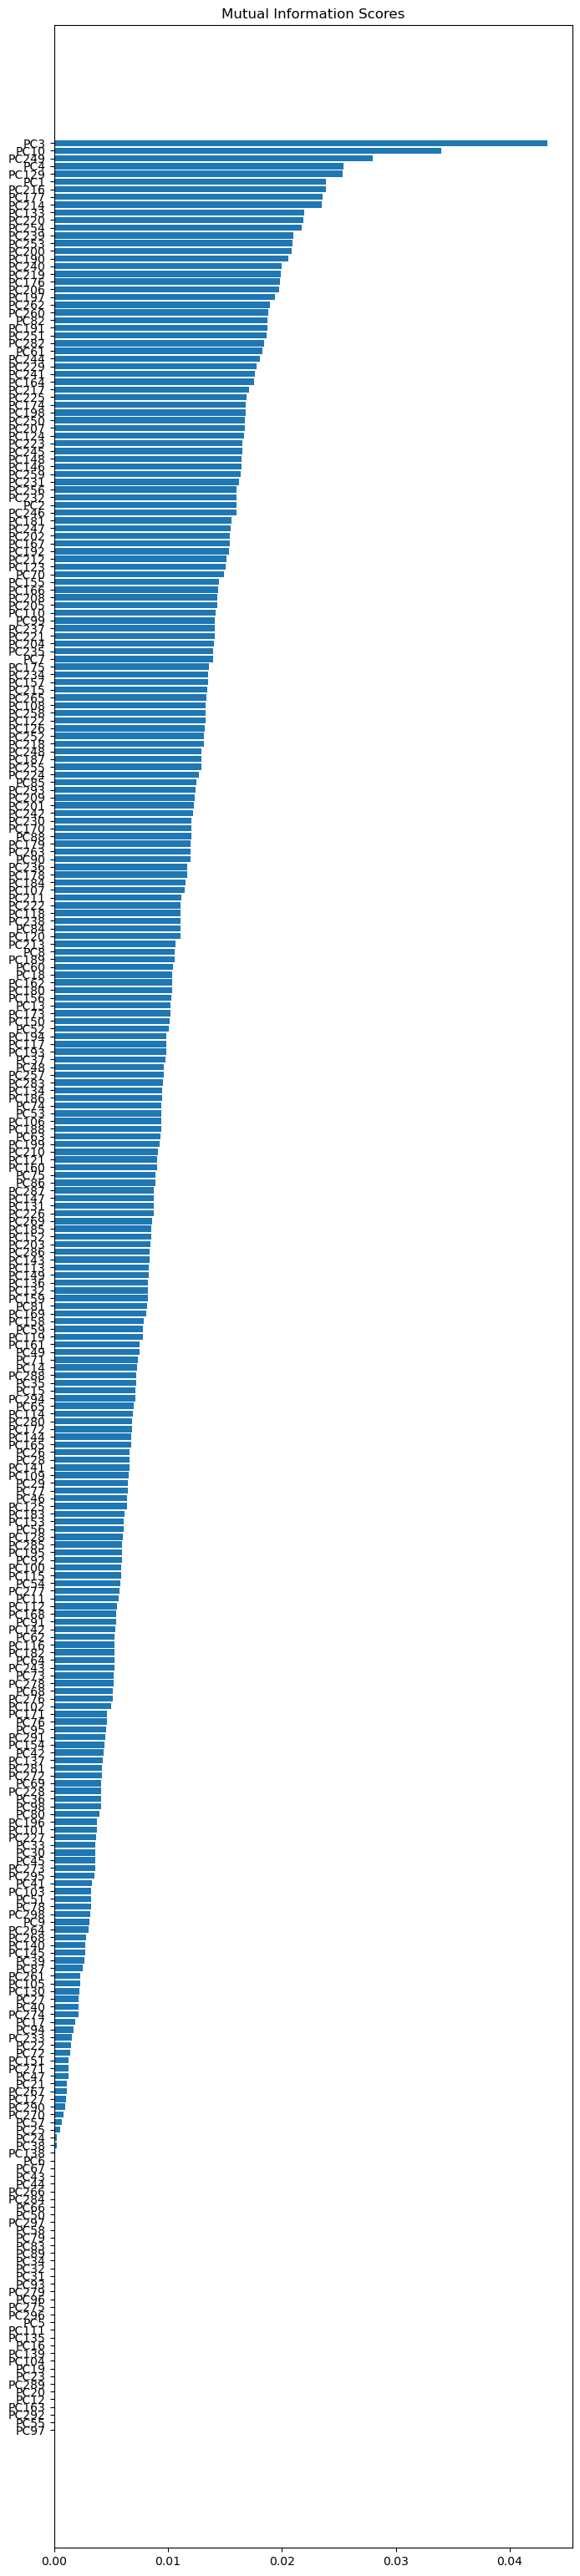

In [21]:
#hide_input
plt.figure(dpi=100, figsize=(8,40))
plot_mi_scores(mi_scores2)

In [18]:
loadings['PC3'].sort_values()

DEM_LOCATION_6   -0.199880
DEM_REGION_3     -0.199880
MENT_NONE        -0.194210
DEM_REGION_4     -0.190116
TOB_FREQ_USE_3   -0.083645
                    ...   
MENT_ANX          0.153454
ILL_USE           0.198791
QLANG_2           0.361649
DEM_LOCATION_5    0.406635
DEM_REGION_2      0.406635
Name: PC3, Length: 298, dtype: float64

This shows that People from Quebec explained a lot of our misuses.

In [27]:
print(loadings['PC10'].sort_values()[-10:])
print(loadings['PC10'].sort_values()[:10])

ILL_USE               0.086083
PAIN_ACUTE_RX_1.0     0.090604
DEM_AGE10_5           0.096545
MENT_DEP              0.107322
PAIN_ACUTE_DOC_5.0    0.109052
DEM_EDU_4             0.115923
DEM_GENDER_2          0.116964
PAIN_ACUTE            0.121690
CAN_REC_USE_5         0.245234
CAN_USE_5             0.248157
Name: PC10, dtype: float64
COD_USE           -0.407855
OP_USE            -0.393993
RXDRUGSAFE_THER   -0.273934
RXDRUGSAFE_HIGH   -0.179127
MENT_NONE         -0.165463
RXDRUGSAFE_PAIN   -0.160594
MORPH_USE         -0.158221
ILL_YR            -0.155839
ILL_MNTH          -0.119243
OXY_USE           -0.104601
Name: PC10, dtype: float64


In [52]:
loadings['PC249'].sort_values()

SPICE_USE_5         -0.291527
OPIOID_DEP_BUP      -0.215010
SAL_USE_4           -0.161043
KET_USE_2           -0.148963
CAN_REC_USE_3       -0.143733
                       ...   
DEM_ABOR_TYPE_3.0    0.212889
CAN_USE_3            0.225977
MEPH_USE_4           0.232597
OPIOID_DEP_OTH       0.267304
MEPH_USE_5           0.294297
Name: PC249, Length: 298, dtype: float64

In [53]:
loadings['PC4'].sort_values()

DAST_CAT_2      -0.346991
DAST_SUM_1      -0.317966
CAN_USE_5       -0.293073
CAN_REC_USE_5   -0.289556
COD_USE         -0.133666
                   ...   
DEM_AGE          0.141724
CAN_USE_2        0.157341
ILL_YR           0.165930
ILL_WK           0.170410
ILL_MNTH         0.174219
Name: PC4, Length: 298, dtype: float64

Canabis users who hasn't is far from using cocain and opium

In [23]:
loadings['PC129'].sort_values()

OXYM_USE                -0.437721
DAST_6                  -0.334121
MENT_EAT                -0.319947
HELP_SUB_USE_ALC        -0.160578
WT_5901.566878980892    -0.138589
                           ...   
WT_5138.206030150754     0.097945
WT_3289.8143459915614    0.111133
DAST_10                  0.151550
MENT_ADHD                0.166972
METH_USE                 0.320250
Name: PC129, Length: 298, dtype: float64

Heavy Meth users

In [24]:
loadings['PC1'].sort_values()

DEM_AGE          -0.790672
DEM_AGE10_6      -0.237118
MENT_NONE        -0.105141
DEM_AGE10_5      -0.099928
TOB_FREQ_USE_3   -0.099894
                    ...   
ILL_MNTH          0.119811
ILL_YR            0.143543
DEM_AGE10_2       0.144780
ILL_USE           0.145715
DEM_MARITAL_6     0.147467
Name: PC1, Length: 298, dtype: float64

Single never, married really young people

## Random Forest Classifier

For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data. [credit](https://medium.com/swlh/random-forest-classification-and-its-implementation-d5d840dbead0#:~:text=For%20data%20including%20categorical%20variables,for%20this%20type%20of%20data.)

In [86]:
rnd_clf = RandomForestClassifier(criterion='gini',max_depth=16,max_features='auto',max_leaf_nodes=64,n_estimators= 4000,n_jobs=-1, random_state=27)
rnd_clf.fit(X_train, y_train)

# Grid searched
# rnd_clf = RandomForestClassifier(n_jobs=-1, random_state=27)
# param_grid = { 
#     'n_estimators': [2000, 4000],
#     'max_leaf_nodes': [32, 64],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,16,32,64],
#     'criterion' :['gini', 'entropy']
# }
# cv_rnd_clf = GridSearchCV(estimator=rnd_clf, param_grid=param_grid, cv=5)
# cv_rnd_clf.fit(X_train, y_train)

# Grid search result
#cv_rnd_clf.best_params_
#{'criterion': 'gini','max_depth': 16,'max_features': 'auto','max_leaf_nodes': 64,'n_estimators': 4000}

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=27),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [32, 64],
                         'n_estimators': [2000, 4000]})

In [93]:
y_test_pred = cv_rnd_clf.predict(X_test)
test_acc = np.sum(y_test_pred == y_test)/len(y_test)
print ("\nAUC - ROC : ", roc_auc_score(y_test,cv_rnd_clf.predict(X_test)))
print("test accuracy: "+str(test_acc))


AUC - ROC :  0.6800791380370559
test accuracy: 0.7467532467532467


RandomForestClassifier(max_depth=16, max_leaf_nodes=64, n_estimators=4000,
                       n_jobs=-1, random_state=27)

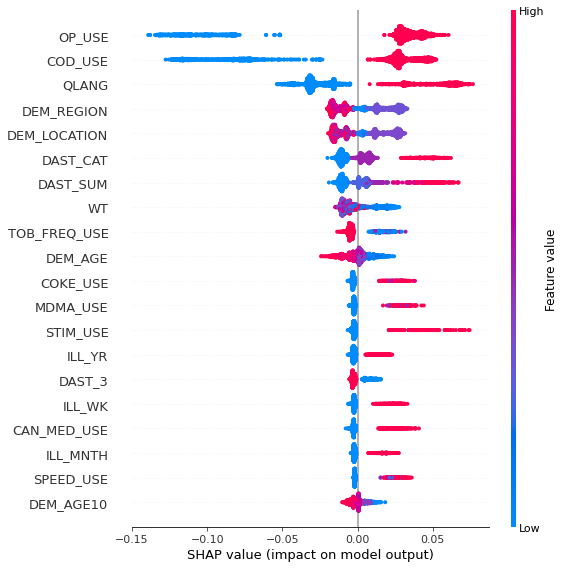

In [94]:
explainer = shap.TreeExplainer(rnd_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test)

# Extras

## Correlation map of different drugs

## Question two: Are people lying about misuse?

In [118]:
print("Percentage of Q.64:  "+str(df.HPC_USE.mean()))
print("Percentage of Q.65:  "+str(df.HPC_SELL.mean()))

Percentage of Q.64:  0.12705882352941175
Percentage of Q.65:  0.04470588235294118


## Looking at time it took to complete survey

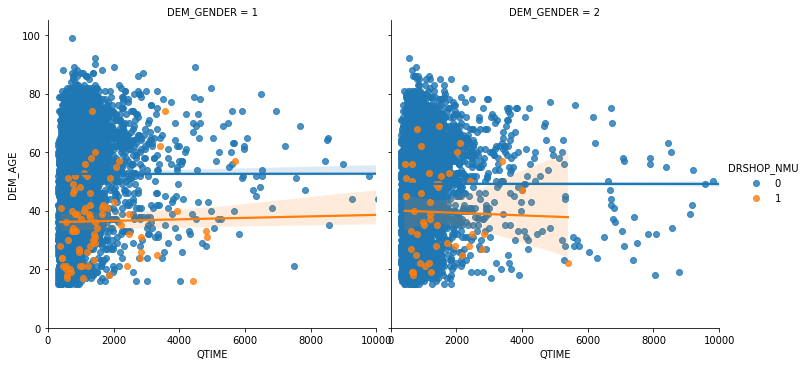

In [117]:
lm1 = sns.lmplot(x="QTIME", y="DEM_AGE", hue="DRSHOP_NMU", col="DEM_GENDER", data=df).set(xlim=(0,10000),ylim=(0,105))

Looks like it was a pretty short survey. Minimum completion time was about 5min and most surveys took around that time to 35 minutes. Some people took literally few days to complete (maximum was about 12 days)

### Looking at Age gap between DRSHOP_NMU

In [1]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
box1 = sns.boxplot(x="DRSHOP_NMU", y="DEM_AGE", hue="DEM_GENDER", data=df, ax=ax[0])
box2 = sns.boxplot(x="DRSHOP_NMU", y="DEM_AGE", hue="DEM_ABOR", data=df, ax=ax[1])

NameError: name 'plt' is not defined

## Citation
